<a href="https://colab.research.google.com/github/springboardmentor789r/AgriYield/blob/Intern_Siddhardha/AgriYeild_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas numpy matplotlib seaborn scikit-learn scipy category_encoders


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
import os

# Sklearn imports
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from scipy import stats
from scipy.stats import chi2_contingency, f_oneway

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 4.2 MB/s eta 0:00:00


In [2]:
try:
    import category_encoders as ce
except ImportError:
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "category_encoders"])
    import category_encoders as ce

warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

print("=" * 90)
print(" " * 20 + "AGRIYIELD PREDICTOR - MILESTONE 1 & 2")
print(" " * 15 + "Complete ML Pipeline Implementation")
print("=" * 90)

                    AGRIYIELD PREDICTOR - MILESTONE 1 & 2
               Complete ML Pipeline Implementation


In [3]:
print("\n" + "=" * 90)
print("MILESTONE 1: DATA COLLECTION & PREPROCESSING")
print("=" * 90)



MILESTONE 1: DATA COLLECTION & PREPROCESSING


In [4]:

print("\n[STEP 1.1] Loading Datasets...")

try:
    crop_df = pd.read_csv('/content/drive/MyDrive/dataset/crop.csv')
    soil_df = pd.read_csv('/content/drive/MyDrive/dataset/soil.csv')
    weather_df = pd.read_csv('/content/drive/MyDrive/dataset/weather.csv')
    print("✓ All datasets loaded successfully from Google Drive!")

    print(f"\n📊 Dataset Dimensions:")
    print(f"  • Crop Dataset:    {crop_df.shape[0]:,} rows × {crop_df.shape[1]} columns")
    print(f"  • Soil Dataset:    {soil_df.shape[0]:,} rows × {soil_df.shape[1]} columns")
    print(f"  • Weather Dataset: {weather_df.shape[0]:,} rows × {weather_df.shape[1]} columns")

except Exception as e:
    print(f"✗ Error: {e}")
    print("\n⚠ Creating sample datasets for demonstration...")

    np.random.seed(42)
    n_samples = 1000

    crop_df = pd.DataFrame({
        'crop_id': range(1, n_samples + 1),
        'crop_type': np.random.choice(['Wheat', 'Rice', 'Corn', 'Barley', 'Soybean'], n_samples),
        'crop_yield': np.random.uniform(20, 100, n_samples),
        'region': np.random.choice(['North', 'South', 'East', 'West'], n_samples),
        'date': pd.date_range('2020-01-01', periods=n_samples, freq='D')
    })

    soil_df = pd.DataFrame({
        'crop_id': range(1, n_samples + 1),
        'soil_type': np.random.choice(['Loamy', 'Sandy', 'Clay', 'Peaty', 'Saline'], n_samples),
        'soil_ph': np.random.uniform(5, 8, n_samples),
        'nitrogen': np.random.uniform(40, 100, n_samples),
        'phosphorus': np.random.uniform(30, 80, n_samples),
        'potassium': np.random.uniform(25, 70, n_samples),
        'soil_quality': np.random.uniform(10, 80, n_samples)
    })

    weather_df = pd.DataFrame({
        'crop_id': range(1, n_samples + 1),
        'temperature': np.random.uniform(10, 35, n_samples),
        'humidity': np.random.uniform(60, 95, n_samples),
        'rainfall': np.random.uniform(0, 200, n_samples),
        'wind_speed': np.random.uniform(0, 15, n_samples)
    })


[STEP 1.1] Loading Datasets...
✓ All datasets loaded successfully from Google Drive!

📊 Dataset Dimensions:
  • Crop Dataset:    2,200 rows × 8 columns
  • Soil Dataset:    15,400 rows × 19 columns
  • Weather Dataset: 478,376 rows × 14 columns


In [5]:
print("\n[STEP 1.2] Initial Data Exploration...")

def display_dataset_info(df, name):
    """Display comprehensive information about a dataset"""
    print(f"\n{'='*80}")
    print(f"{name} Dataset Information")
    print(f"{'='*80}")

    print(f"\n📋 Column Names and Types:")
    print(df.dtypes)

    print(f"\n📊 Basic Statistics:")
    print(df.describe())

    print(f"\n🔍 Missing Values:")
    missing = df.isnull().sum()
    missing_pct = (missing / len(df)) * 100
    missing_df = pd.DataFrame({
        'Missing_Count': missing,
        'Percentage': missing_pct
    })
    missing_info = missing_df[missing_df['Missing_Count'] > 0]
    if len(missing_info) > 0:
        print(missing_info)
    else:
        print("  ✓ No missing values found!")

    print(f"\n🔢 Sample Data (First 5 Rows):")
    print(df.head())

display_dataset_info(crop_df, "CROP")
display_dataset_info(soil_df, "SOIL")
display_dataset_info(weather_df, "WEATHER")



[STEP 1.2] Initial Data Exploration...

CROP Dataset Information

📋 Column Names and Types:
N                int64
P                int64
K                int64
temperature    float64
humidity       float64
ph             float64
rainfall       float64
label           object
dtype: object

📊 Basic Statistics:
                 N            P            K  temperature     humidity  \
count  2200.000000  2200.000000  2200.000000  2200.000000  2200.000000   
mean     50.551818    53.362727    48.149091    25.616244    71.481779   
std      36.917334    32.985883    50.647931     5.063749    22.263812   
min       0.000000     5.000000     5.000000     8.825675    14.258040   
25%      21.000000    28.000000    20.000000    22.769375    60.261953   
50%      37.000000    51.000000    32.000000    25.598693    80.473146   
75%      84.250000    68.000000    49.000000    28.561654    89.948771   
max     140.000000   145.000000   205.000000    43.675493    99.981876   

                ph   

In [6]:
print("\n[STEP 1.3] Data Cleaning...")

def clean_dataset(df, name):
    """Clean a dataset by handling missing values and duplicates"""
    print(f"\n🧹 Cleaning {name} Dataset...")

    df_clean = df.copy()
    initial_rows = len(df_clean)
    initial_missing = df_clean.isnull().sum().sum()

    # Remove duplicates
    df_clean = df_clean.drop_duplicates()
    duplicates_removed = initial_rows - len(df_clean)

    # Handle missing values
    for col in df_clean.columns:
        if df_clean[col].isnull().sum() > 0:
            if df_clean[col].dtype in ['float64', 'int64']:
                # Fill numerical columns with median
                df_clean[col].fillna(df_clean[col].median(), inplace=True)
            else:
                # Fill categorical columns with mode
                mode_val = df_clean[col].mode()
                fill_value = mode_val[0] if len(mode_val) > 0 else 'Unknown'
                df_clean[col].fillna(fill_value, inplace=True)

    final_missing = df_clean.isnull().sum().sum()

    print(f"  ✓ Removed {duplicates_removed} duplicate rows")
    print(f"  ✓ Filled {initial_missing - final_missing} missing values")
    print(f"  ✓ Final shape: {df_clean.shape}")

    return df_clean

crop_df_clean = clean_dataset(crop_df, "CROP")
soil_df_clean = clean_dataset(soil_df, "SOIL")
weather_df_clean = clean_dataset(weather_df, "WEATHER")



[STEP 1.3] Data Cleaning...

🧹 Cleaning CROP Dataset...
  ✓ Removed 0 duplicate rows
  ✓ Filled 0 missing values
  ✓ Final shape: (2200, 8)

🧹 Cleaning SOIL Dataset...
  ✓ Removed 0 duplicate rows
  ✓ Filled 0 missing values
  ✓ Final shape: (15400, 19)

🧹 Cleaning WEATHER Dataset...
  ✓ Removed 0 duplicate rows
  ✓ Filled 10188 missing values
  ✓ Final shape: (478376, 14)


In [7]:
print("\n[STEP 1.4] Merging Datasets...")

print(f"\n🔗 Identifying merge keys...")
print(f"Crop columns: {list(crop_df_clean.columns)}")
print(f"Soil columns: {list(soil_df_clean.columns)}")
print(f"Weather columns: {list(weather_df_clean.columns)}")

# Find common columns
common_crop_soil = set(crop_df_clean.columns) & set(soil_df_clean.columns)
common_crop_weather = set(crop_df_clean.columns) & set(weather_df_clean.columns)
common_all = set(crop_df_clean.columns) & set(soil_df_clean.columns) & set(weather_df_clean.columns)

print(f"\n📍 Common columns found:")
print(f"  • Crop-Soil common: {common_crop_soil if common_crop_soil else 'None'}")
print(f"  • Crop-Weather common: {common_crop_weather if common_crop_weather else 'None'}")
print(f"  • All three common: {common_all if common_all else 'None'}")

# Merge datasets
possible_keys = ['crop_id', 'id', 'date', 'region', 'location']
merge_key = None

for key in possible_keys:
    if key in common_all:
        merge_key = key
        break

if merge_key:
    print(f"\n✓ Using '{merge_key}' as merge key")
    merged_df = crop_df_clean.merge(soil_df_clean, on=merge_key, how='inner', suffixes=('', '_soil'))
    merged_df = merged_df.merge(weather_df_clean, on=merge_key, how='inner', suffixes=('', '_weather'))
    print(f"✓ Inner merge completed successfully!")
else:
    print(f"\n⚠ No common merge key found. Using index-based concatenation...")
    min_len = min(len(crop_df_clean), len(soil_df_clean), len(weather_df_clean))
    merged_df = pd.concat([
        crop_df_clean.iloc[:min_len].reset_index(drop=True),
        soil_df_clean.iloc[:min_len].reset_index(drop=True),
        weather_df_clean.iloc[:min_len].reset_index(drop=True)
    ], axis=1)
    print(f"✓ Concatenation completed!")

# Remove duplicate columns
merged_df = merged_df.loc[:, ~merged_df.columns.duplicated()]

print(f"\n📊 Merged Dataset Shape: {merged_df.shape}")
print(f"  • Total rows: {merged_df.shape[0]:,}")
print(f"  • Total columns: {merged_df.shape[1]}")
print(f"\n📋 Merged Dataset Preview:")
print(merged_df.head())


[STEP 1.4] Merging Datasets...

🔗 Identifying merge keys...
Crop columns: ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall', 'label']
Soil columns: ['Name', 'Fertility', 'Photoperiod', 'Temperature', 'Rainfall', 'pH', 'Light_Hours', 'Light_Intensity', 'Rh', 'Nitrogen', 'Phosphorus', 'Potassium', 'Yield', 'Category_pH', 'Soil_Type', 'Season', 'N_Ratio', 'P_Ratio', 'K_Ratio']
Weather columns: ['EventId', 'Type', 'Severity', 'StartTime(UTC)', 'EndTime(UTC)', 'Precipitation(in)', 'TimeZone', 'AirportCode', 'LocationLat', 'LocationLng', 'City', 'County', 'State', 'ZipCode']

📍 Common columns found:
  • Crop-Soil common: None
  • Crop-Weather common: None
  • All three common: None

⚠ No common merge key found. Using index-based concatenation...
✓ Concatenation completed!

📊 Merged Dataset Shape: (2200, 41)
  • Total rows: 2,200
  • Total columns: 41

📋 Merged Dataset Preview:
    N   P   K  temperature   humidity        ph    rainfall label        Name  \
0  90  42  43    20.8797

In [8]:
print("\n[STEP 1.5] Data Standardization...")

# Convert date columns to datetime
date_columns = [col for col in merged_df.columns if 'date' in col.lower()]
for col in date_columns:
    try:
        merged_df[col] = pd.to_datetime(merged_df[col], errors='coerce')
        print(f"✓ Converted '{col}' to datetime")
    except Exception as e:
        print(f"✗ Could not convert '{col}' to datetime: {e}")

# Standardize column names
merged_df.columns = merged_df.columns.str.lower().str.replace(' ', '_').str.replace('-', '_')
print(f"\n✓ Standardized column names")

# Identify column types
numerical_cols = merged_df.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_cols = merged_df.select_dtypes(include=['object']).columns.tolist()
datetime_cols = merged_df.select_dtypes(include=['datetime64']).columns.tolist()

print(f"\n📊 Column Classification:")
print(f"  • Numerical columns ({len(numerical_cols)}): {numerical_cols[:10]}{'...' if len(numerical_cols) > 10 else ''}")
print(f"  • Categorical columns ({len(categorical_cols)}): {categorical_cols[:10]}{'...' if len(categorical_cols) > 10 else ''}")
print(f"  • DateTime columns ({len(datetime_cols)}): {datetime_cols}")

# Save cleaned and merged dataset
merged_df.to_csv('merged_crop_data_cleaned.csv', index=False)
print(f"\n✓ Cleaned and merged dataset saved as 'merged_crop_data_cleaned.csv'")

print("\n" + "=" * 90)
print("✅ MILESTONE 1 COMPLETED SUCCESSFULLY!")
print("=" * 90)


[STEP 1.5] Data Standardization...

✓ Standardized column names

📊 Column Classification:
  • Numerical columns (24): ['n', 'p', 'k', 'temperature', 'humidity', 'ph', 'rainfall', 'temperature', 'rainfall', 'ph']...
  • Categorical columns (17): ['label', 'name', 'fertility', 'photoperiod', 'category_ph', 'soil_type', 'season', 'eventid', 'type', 'severity']...
  • DateTime columns (0): []

✓ Cleaned and merged dataset saved as 'merged_crop_data_cleaned.csv'

✅ MILESTONE 1 COMPLETED SUCCESSFULLY!


MileStone:2


In [9]:
print("\n" + "=" * 90)
print("MILESTONE 2: EXPLORATORY DATA ANALYSIS & FEATURE ENGINEERING")
print("=" * 90)



MILESTONE 2: EXPLORATORY DATA ANALYSIS & FEATURE ENGINEERING


In [10]:
print("\n[STEP 2.1] Target Variable Analysis...")

# Identify target variable
target_candidates = [col for col in merged_df.columns if 'yield' in col.lower()]

if target_candidates:
    target_col = target_candidates[0]
    print(f"\n✓ Target variable identified: '{target_col}'")
else:
    possible_targets = ['production', 'output', 'harvest']
    target_col = None

    for possible in possible_targets:
        candidates = [col for col in merged_df.columns if possible in col.lower()]
        if candidates:
            target_col = candidates[0]
            break

    if target_col is None and len(numerical_cols) > 0:
        target_col = numerical_cols[-1]

    print(f"\n⚠ No 'yield' column found. Using '{target_col}' as target variable.")

# Ensure target is numerical
if target_col not in numerical_cols:
    print(f"\n⚠ Converting '{target_col}' to numerical...")
    try:
        merged_df[target_col] = pd.to_numeric(merged_df[target_col], errors='coerce')
        merged_df[target_col].fillna(merged_df[target_col].median(), inplace=True)
        numerical_cols.append(target_col)
        print(f"✓ Successfully converted '{target_col}' to numerical")
    except Exception as e:
        print(f"✗ Could not convert: {e}")


[STEP 2.1] Target Variable Analysis...

✓ Target variable identified: 'yield'


In [12]:
print(f"\n📊 Target Variable ('{target_col}') Statistics:")
target_stats = merged_df[target_col].describe()
print(target_stats)

print(f"\n📈 Additional Statistics:")
print(f"  • Skewness: {merged_df[target_col].skew():.4f}")
print(f"  • Kurtosis: {merged_df[target_col].kurtosis():.4f}")
print(f"  • Range: {merged_df[target_col].max() - merged_df[target_col].min():.4f}")
print(f"  • IQR: {merged_df[target_col].quantile(0.75) - merged_df[target_col].quantile(0.25):.4f}")


📊 Target Variable ('yield') Statistics:
count    2200.000000
mean       25.897487
std        15.839952
min         5.402109
25%        12.244721
50%        19.902854
75%        47.147599
max        53.671584
Name: yield, dtype: float64

📈 Additional Statistics:
  • Skewness: 0.6125
  • Kurtosis: -1.3780
  • Range: 48.2695
  • IQR: 34.9029


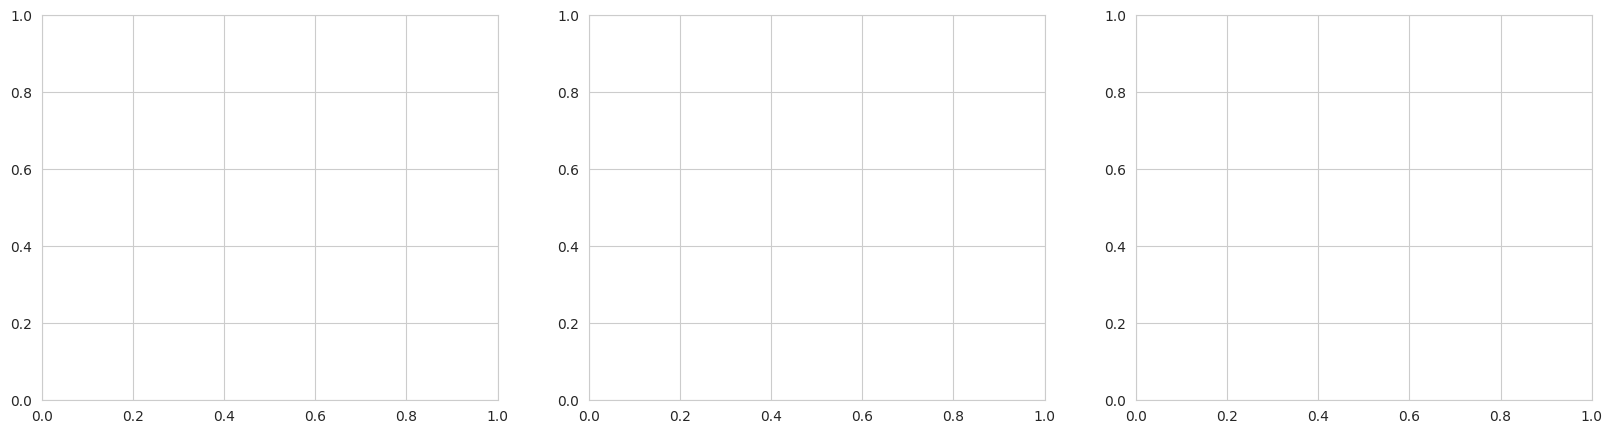

In [13]:
# Visualize target distribution
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
target_data = merged_df[target_col].dropna()

In [16]:
# Box plot
bp = axes[1].boxplot(target_data, vert=True, patch_artist=True,
                      boxprops=dict(facecolor='lightgreen', alpha=0.7),
                      medianprops=dict(color='red', linewidth=2))
axes[1].set_title(f'Box Plot of {target_col}', fontsize=14, weight='bold')
axes[1].set_ylabel(target_col, fontsize=12)
axes[1].grid(alpha=0.3)

In [17]:
# Q-Q plot
stats.probplot(target_data, dist="norm", plot=axes[2])
axes[2].set_title(f'Q-Q Plot of {target_col}', fontsize=14, weight='bold')
axes[2].grid(alpha=0.3)


In [18]:
# Q-Q plot
stats.probplot(target_data, dist="norm", plot=axes[2])
axes[2].set_title(f'Q-Q Plot of {target_col}', fontsize=14, weight='bold')
axes[2].grid(alpha=0.3)


In [19]:
plt.tight_layout()
plt.savefig('01_target_variable_analysis.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Target variable analysis plots saved")

<Figure size 1400x600 with 0 Axes>

✓ Target variable analysis plots saved



[STEP 2.2] Univariate Analysis...

📊 Analyzing 23 numerical features...


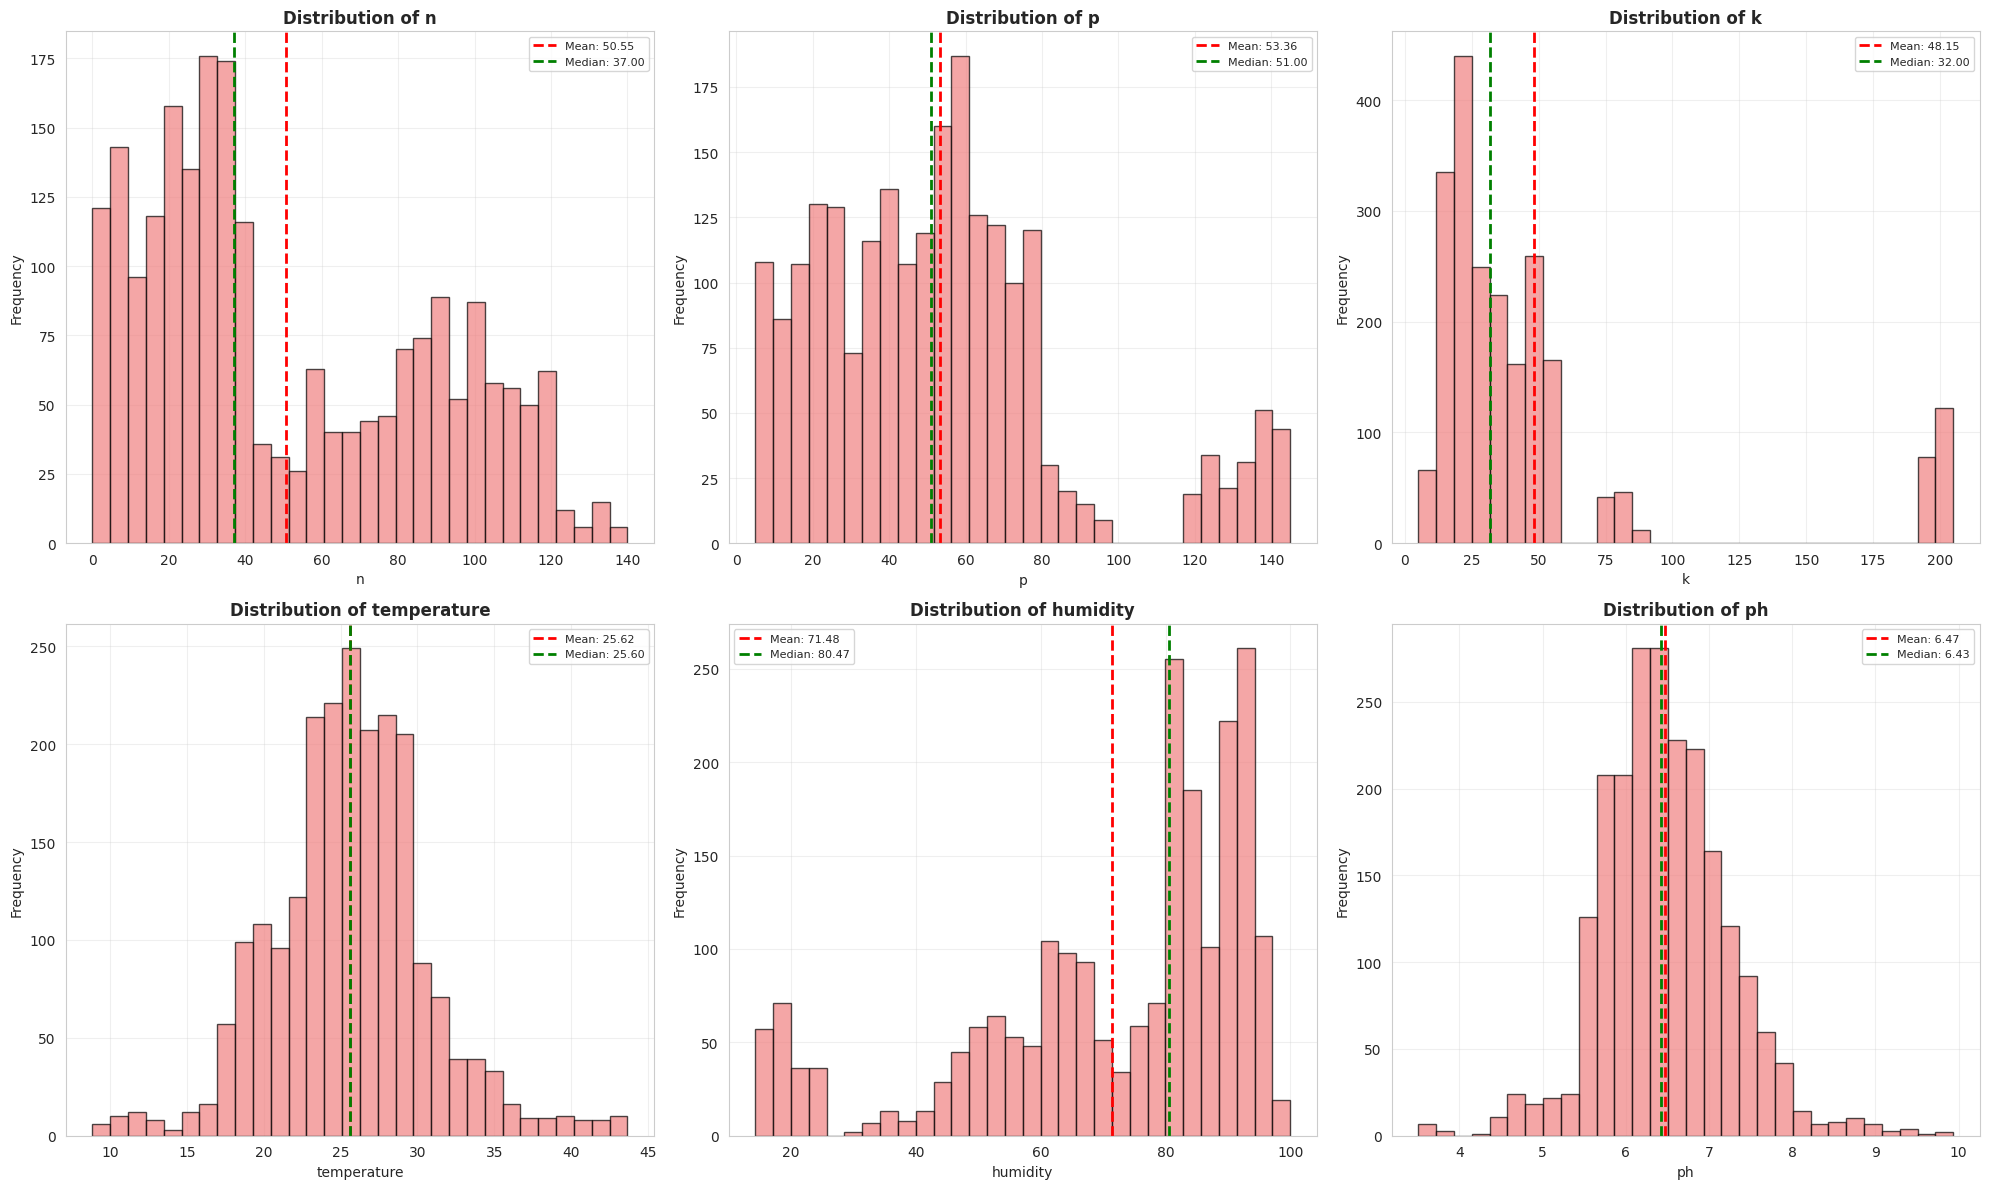

✓ Numerical analysis plots saved


In [23]:
print("\n[STEP 2.2] Univariate Analysis...")

# Remove duplicate columns based on column names
merged_df = merged_df.loc[:, ~merged_df.columns.duplicated()]

feature_numerical = [col for col in numerical_cols if col != target_col]
feature_categorical = categorical_cols.copy()

# Numerical features analysis
if len(feature_numerical) > 0:
    print(f"\n📊 Analyzing {len(feature_numerical)} numerical features...")

    num_features_to_plot = min(len(feature_numerical), 6)
    top_num_features = feature_numerical[:num_features_to_plot]

    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    axes = axes.ravel()

    for idx, col in enumerate(top_num_features):
        # Access the column data directly from merged_df
        data = merged_df[col].dropna()
        axes[idx].hist(data, bins=30, color='lightcoral', edgecolor='black', alpha=0.7)
        axes[idx].axvline(data.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {data.mean():.2f}')
        axes[idx].axvline(data.median(), color='green', linestyle='--', linewidth=2, label=f'Median: {data.median():.2f}')
        axes[idx].set_title(f'Distribution of {col}', fontsize=12, weight='bold')
        axes[idx].set_xlabel(col, fontsize=10)
        axes[idx].set_ylabel('Frequency', fontsize=10)
        axes[idx].legend(fontsize=8)
        axes[idx].grid(alpha=0.3)

    for idx in range(num_features_to_plot, 6):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.savefig('02_univariate_numerical_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✓ Numerical analysis plots saved")

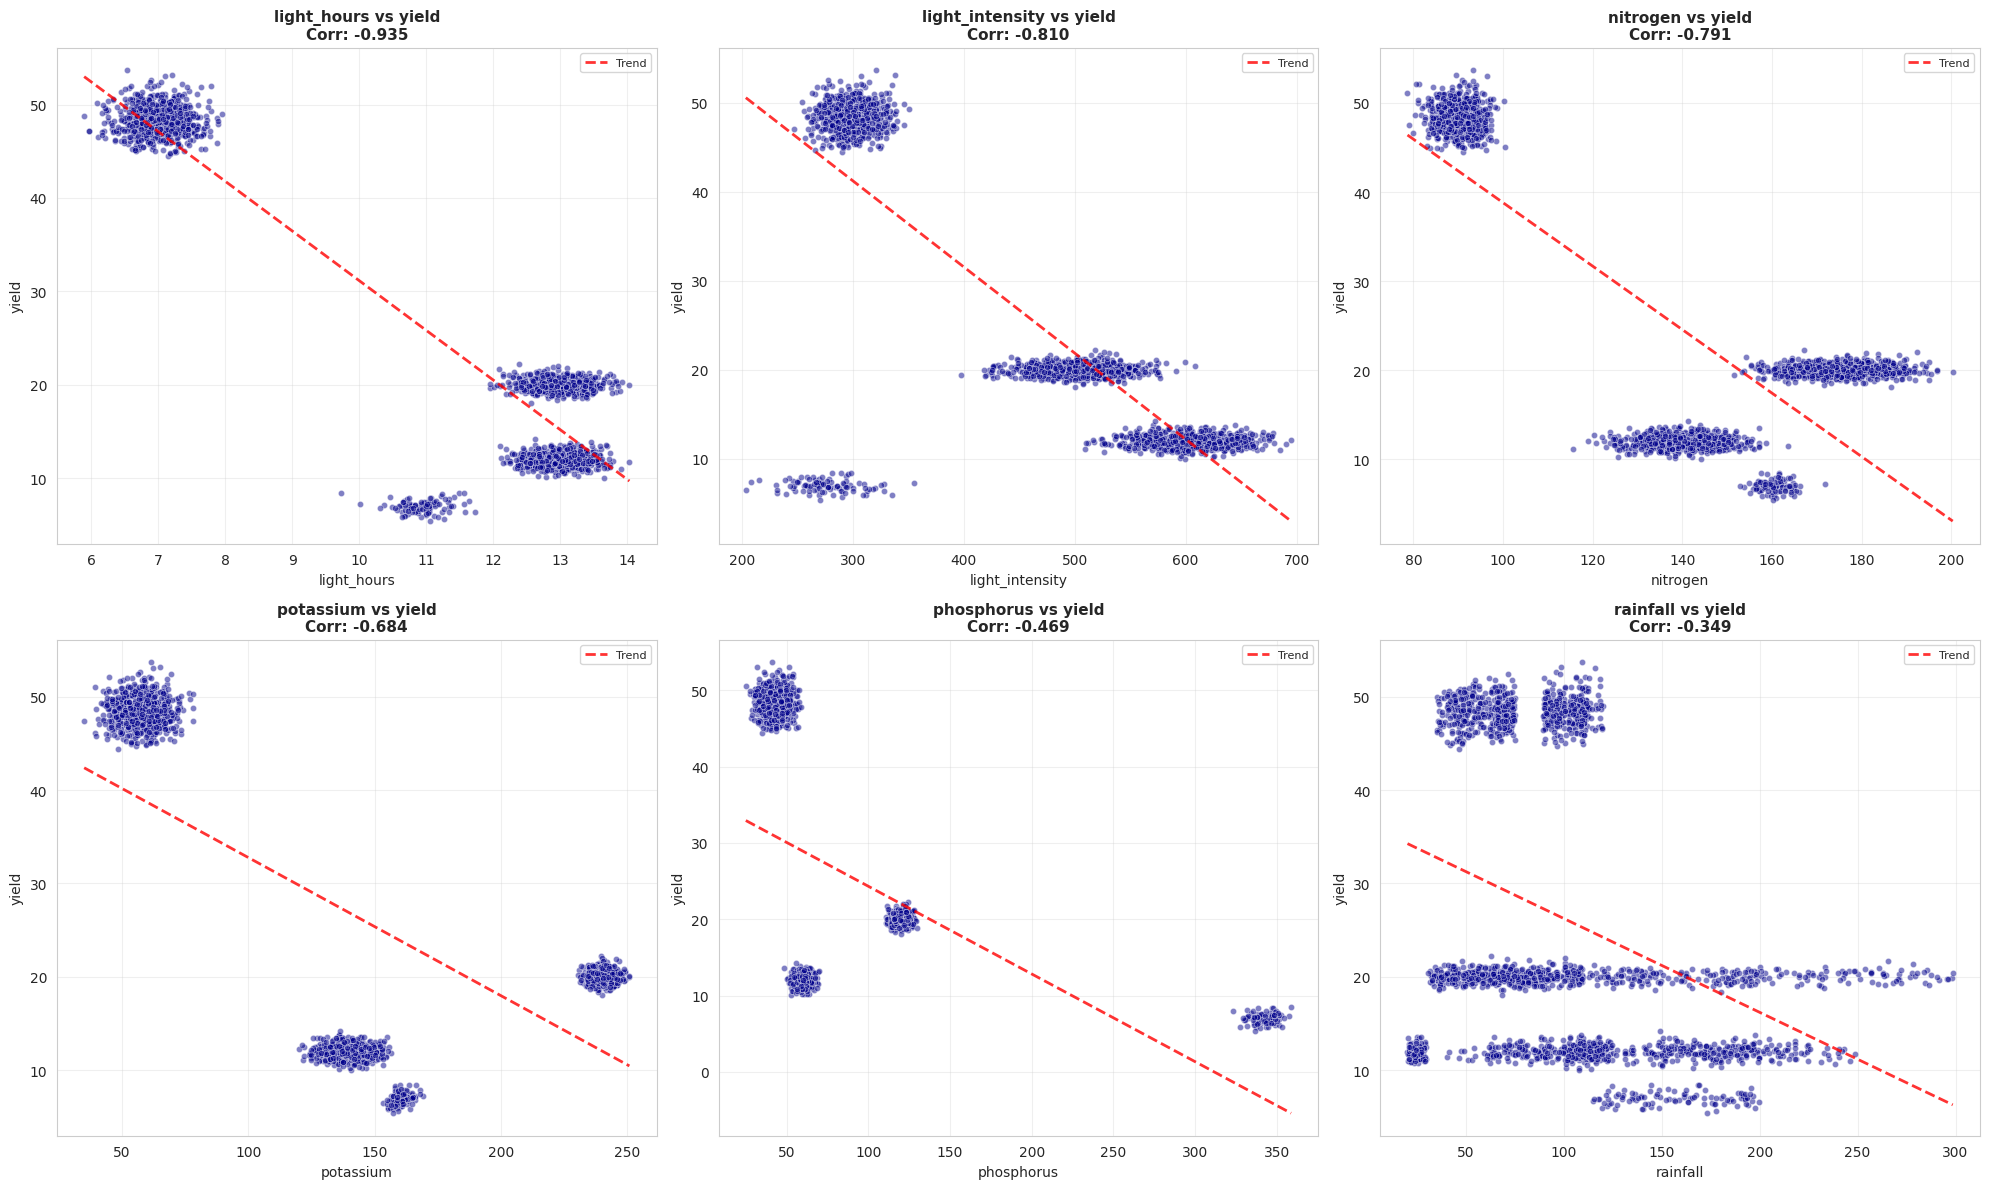

✓ Scatter plot analysis saved


In [32]:
# Remove duplicate columns from correlation_matrix
correlation_matrix = correlation_matrix.loc[:, ~correlation_matrix.columns.duplicated()]
correlation_matrix = correlation_matrix.T.loc[:, ~correlation_matrix.T.columns.duplicated()].T

correlations = correlation_matrix[target_col].drop(target_col)

top_correlated = correlations.abs().sort_values(ascending=False).head(6).index.tolist()

if len(top_correlated) > 0:
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    axes = axes.ravel()

    for idx, col in enumerate(top_correlated):
        plot_data = merged_df[[col, target_col]].dropna()

        axes[idx].scatter(plot_data[col], plot_data[target_col],
                         alpha=0.5, s=20, color='darkblue', edgecolors='white', linewidth=0.5)
        axes[idx].set_title(f'{col} vs {target_col}\nCorr: {correlation_matrix.loc[col, target_col]:.3f}',
                           fontsize=11, weight='bold')
        axes[idx].set_xlabel(col, fontsize=10)
        axes[idx].set_ylabel(target_col, fontsize=10)
        axes[idx].grid(alpha=0.3)

        # Add trend line
        if len(plot_data) > 1:
            try:
                z = np.polyfit(plot_data[col], plot_data[target_col], 1)
                p = np.poly1d(z)
                x_line = np.linspace(plot_data[col].min(), plot_data[col].max(), 100)
                axes[idx].plot(x_line, p(x_line), "r--", alpha=0.8, linewidth=2, label='Trend')
                axes[idx].legend(fontsize=8)
            except:
                pass

    plt.tight_layout()
    plt.savefig('05_bivariate_scatter_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✓ Scatter plot analysis saved")

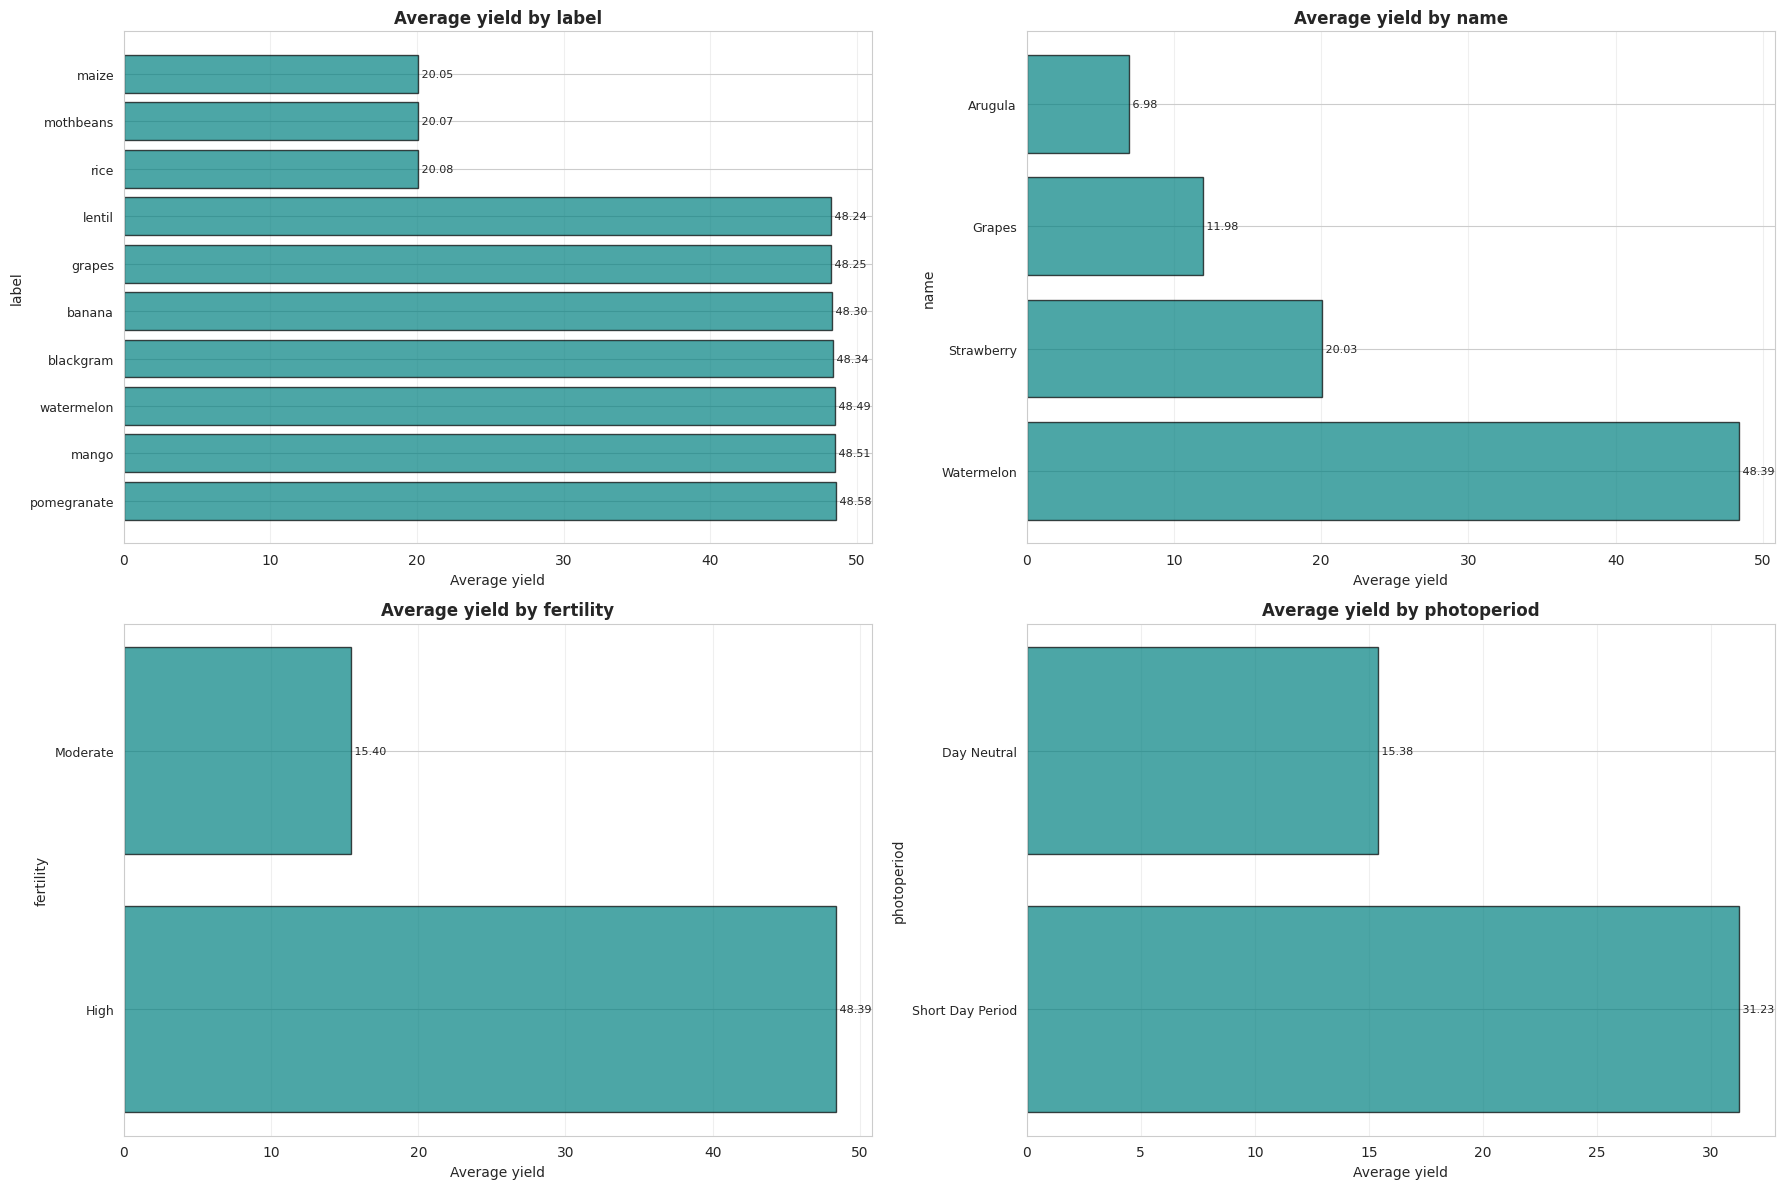

✓ Categorical vs target analysis saved


In [33]:
# Categorical vs Target analysis
if len(feature_categorical) > 0:
    cat_to_plot = min(len(feature_categorical), 4)
    top_cat = feature_categorical[:cat_to_plot]

    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    axes = axes.ravel()

    for idx, col in enumerate(top_cat):
        if idx < len(axes):
            grouped = merged_df.groupby(col)[target_col].mean().sort_values(ascending=False).head(10)

            axes[idx].barh(range(len(grouped)), grouped.values,
                          color='teal', edgecolor='black', alpha=0.7)
            axes[idx].set_title(f'Average {target_col} by {col}', fontsize=12, weight='bold')
            axes[idx].set_xlabel(f'Average {target_col}', fontsize=10)
            axes[idx].set_ylabel(col, fontsize=10)
            axes[idx].set_yticks(range(len(grouped)))
            axes[idx].set_yticklabels(grouped.index, fontsize=9)
            axes[idx].grid(alpha=0.3, axis='x')

            for i, v in enumerate(grouped.values):
                axes[idx].text(v, i, f' {v:.2f}', va='center', fontsize=8)

    for idx in range(cat_to_plot, 4):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.savefig('06_categorical_vs_target_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✓ Categorical vs target analysis saved")



[STEP 2.4] Outlier Detection...

📊 Outlier Detection Results (IQR Method):
                   count  percentage  lower_bound  upper_bound
precipitation(in)  448.0   20.363636     0.000000     0.000000
k                  200.0    9.090909   -23.500000    92.500000
p                  138.0    6.272727   -32.000000   128.000000
rainfall           100.0    4.545455   -25.022047   213.841241
phosphorus         100.0    4.545455   -60.439765   226.262790
rh                 100.0    4.545455    86.172651    96.677634
temperature         86.0    3.909091    14.080956    37.250073
ph                  57.0    2.590909     4.543768     8.351567
humidity            30.0    1.363636    15.731726   134.478998
n                    0.0    0.000000   -73.875000   179.125000
light_intensity      0.0    0.000000   -99.636923   980.166699
light_hours          0.0    0.000000    -1.440809    21.781021
nitrogen             0.0    0.000000   -20.169183   281.285757
potassium            0.0    0.000000  -198

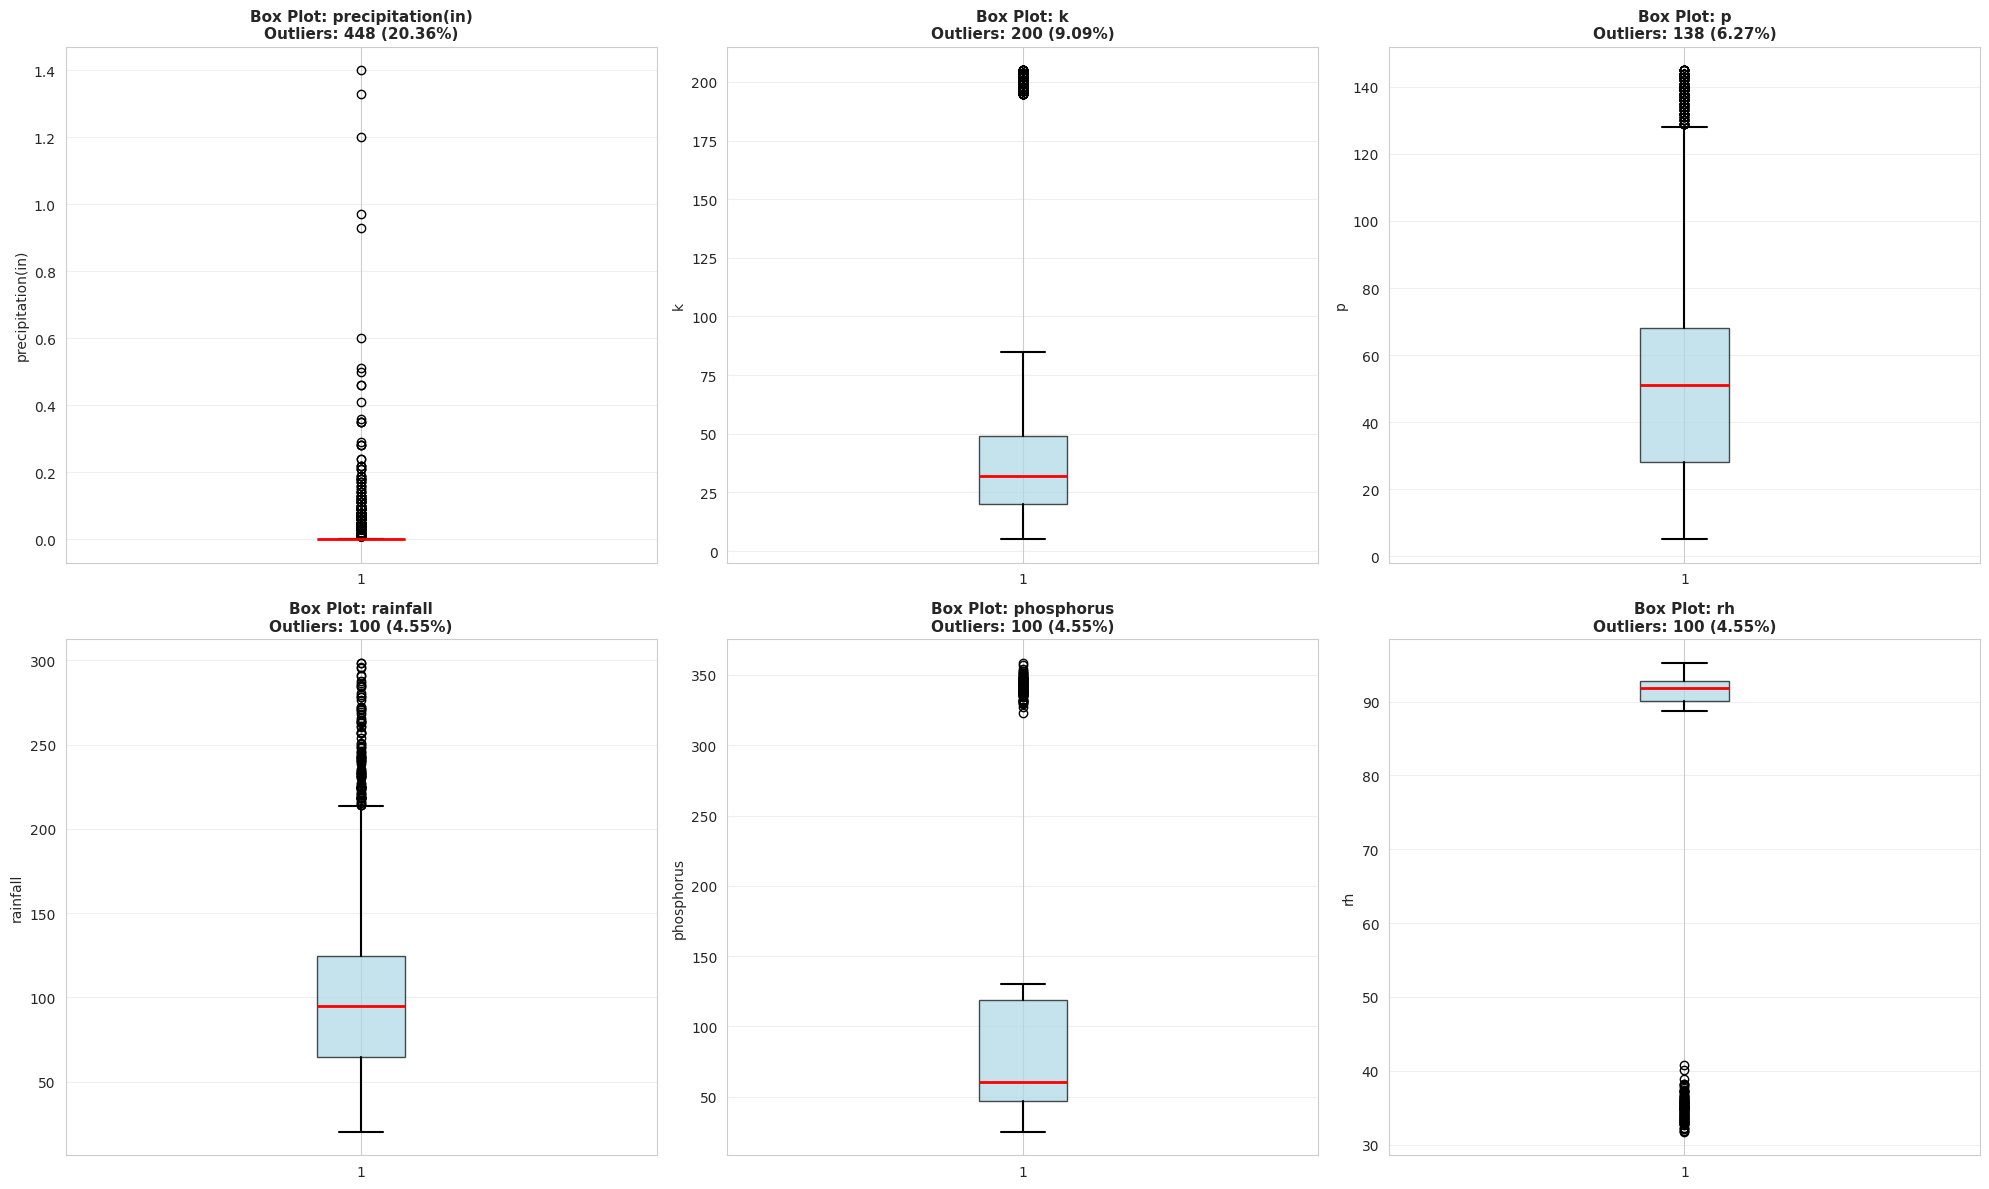

✓ Outlier detection plots saved


In [34]:
print("\n[STEP 2.4] Outlier Detection...")

def detect_outliers_iqr(df, columns):
    """Detect outliers using IQR method"""
    outlier_info = {}

    for col in columns:
        data = df[col].dropna()
        if len(data) > 0:
            Q1 = data.quantile(0.25)
            Q3 = data.quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            outliers = data[(data < lower_bound) | (data > upper_bound)]
            outlier_info[col] = {
                'count': len(outliers),
                'percentage': (len(outliers) / len(data)) * 100,
                'lower_bound': lower_bound,
                'upper_bound': upper_bound
            }

    return outlier_info

outlier_results = detect_outliers_iqr(merged_df, feature_numerical)

print(f"\n📊 Outlier Detection Results (IQR Method):")
outlier_df = pd.DataFrame(outlier_results).T
outlier_df_sorted = outlier_df.sort_values('count', ascending=False)
print(outlier_df_sorted.head(15))

# Visualize outliers
top_outlier_cols = outlier_df_sorted.head(6).index.tolist()

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.ravel()

for idx, col in enumerate(top_outlier_cols):
    data = merged_df[col].dropna()

    bp = axes[idx].boxplot(data, vert=True, patch_artist=True,
                           boxprops=dict(facecolor='lightblue', alpha=0.7),
                           medianprops=dict(color='red', linewidth=2),
                           whiskerprops=dict(linewidth=1.5),
                           capprops=dict(linewidth=1.5))

    axes[idx].set_title(f'Box Plot: {col}\nOutliers: {outlier_results[col]["count"]} ({outlier_results[col]["percentage"]:.2f}%)',
                       fontsize=11, weight='bold')
    axes[idx].set_ylabel(col, fontsize=10)
    axes[idx].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('07_outlier_detection.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Outlier detection plots saved")

In [35]:
print("\n[STEP 2.5] Feature Engineering...")

df_engineered = merged_df.copy()
initial_features = df_engineered.shape[1]

# 1. DateTime Features
if len(datetime_cols) > 0:
    for date_col in datetime_cols:
        df_engineered[f'{date_col}_year'] = df_engineered[date_col].dt.year
        df_engineered[f'{date_col}_month'] = df_engineered[date_col].dt.month
        df_engineered[f'{date_col}_day'] = df_engineered[date_col].dt.day
        df_engineered[f'{date_col}_dayofweek'] = df_engineered[date_col].dt.dayofweek
        df_engineered[f'{date_col}_quarter'] = df_engineered[date_col].dt.quarter
        df_engineered[f'{date_col}_dayofyear'] = df_engineered[date_col].dt.dayofyear
        df_engineered[f'{date_col}_is_weekend'] = (df_engineered[date_col].dt.dayofweek >= 5).astype(int)
        df_engineered[f'{date_col}_week'] = df_engineered[date_col].dt.isocalendar().week
    print(f"✓ Created datetime features from {len(datetime_cols)} date column(s)")



[STEP 2.5] Feature Engineering...


In [36]:
npk_mapping = {
    'nitrogen': ['nitrogen', 'n'],
    'phosphorus': ['phosphorus', 'p'],
    'potassium': ['potassium', 'k']
}

npk_found = {}
for nutrient, variants in npk_mapping.items():
    for variant in variants:
        matches = [col for col in df_engineered.columns if variant == col.lower()]
        if matches:
            npk_found[nutrient] = matches[0]
            break

if len(npk_found) >= 3:
    n_col = npk_found['nitrogen']
    p_col = npk_found['phosphorus']
    k_col = npk_found['potassium']

    # NPK Sum and Mean
    df_engineered['npk_sum'] = df_engineered[n_col] + df_engineered[p_col] + df_engineered[k_col]
    df_engineered['npk_mean'] = df_engineered['npk_sum'] / 3

    # NPK Ratios
    df_engineered['np_ratio'] = df_engineered[n_col] / (df_engineered[p_col] + 0.01)
    df_engineered['nk_ratio'] = df_engineered[n_col] / (df_engineered[k_col] + 0.01)
    df_engineered['pk_ratio'] = df_engineered[p_col] / (df_engineered[k_col] + 0.01)

    # NPK Balance (deviation from mean)
    df_engineered['npk_balance'] = np.abs(df_engineered[n_col] - df_engineered['npk_mean'])

    # NPK Product
    df_engineered['npk_product'] = df_engineered[n_col] * df_engineered[p_col] * df_engineered[k_col]

    print(f"✓ Created NPK interaction features")

✓ Created NPK interaction features


In [37]:
temp_cols = [col for col in df_engineered.columns if 'temp' in col.lower()]
if len(temp_cols) > 0:
    for temp_col in temp_cols:
        # Polynomial features
        df_engineered[f'{temp_col}_squared'] = df_engineered[temp_col] ** 2
        df_engineered[f'{temp_col}_cubed'] = df_engineered[temp_col] ** 3

        # Temperature categories
        df_engineered[f'{temp_col}_category'] = pd.cut(
            df_engineered[temp_col],
            bins=5,
            labels=['Very_Low', 'Low', 'Medium', 'High', 'Very_High']
        )

        # Heat stress indicator (>30°C)
        df_engineered[f'{temp_col}_heat_stress'] = (df_engineered[temp_col] > 30).astype(int)

        # Cold stress indicator (<10°C)
        df_engineered[f'{temp_col}_cold_stress'] = (df_engineered[temp_col] < 10).astype(int)

    print(f"✓ Created temperature-based features")


✓ Created temperature-based features


In [38]:
rainfall_cols = [col for col in df_engineered.columns if 'rain' in col.lower()]
humidity_cols = [col for col in df_engineered.columns if 'humid' in col.lower()]

for rain_col in rainfall_cols:
    # Log transformation
    df_engineered[f'{rain_col}_log'] = np.log1p(df_engineered[rain_col])

    # Square root transformation
    df_engineered[f'{rain_col}_sqrt'] = np.sqrt(df_engineered[rain_col])

    # Rainfall categories
    df_engineered[f'{rain_col}_category'] = pd.cut(
        df_engineered[rain_col],
        bins=[0, 50, 100, 150, 300],
        labels=['Low', 'Medium', 'High', 'Very_High']
    )

    # Drought indicator
    df_engineered[f'{rain_col}_drought'] = (df_engineered[rain_col] < 30).astype(int)

for humid_col in humidity_cols:
    # Log transformation
    df_engineered[f'{humid_col}_log'] = np.log1p(df_engineered[humid_col])

    # Humidity stress (>90%)
    df_engineered[f'{humid_col}_high_stress'] = (df_engineered[humid_col] > 90).astype(int)

if len(rainfall_cols) > 0 or len(humidity_cols) > 0:
    print(f"✓ Created rainfall/humidity features")


✓ Created rainfall/humidity features


In [39]:
if 'temperature' in df_engineered.columns and 'humidity' in df_engineered.columns:
    df_engineered['growing_season_index'] = (df_engineered['temperature'] * df_engineered['humidity']) / 100

    # Optimal growing conditions (temp: 20-30°C, humidity: 70-85%)
    df_engineered['optimal_conditions'] = (
        (df_engineered['temperature'] >= 20) &
        (df_engineered['temperature'] <= 30) &
        (df_engineered['humidity'] >= 70) &
        (df_engineered['humidity'] <= 85)
    ).astype(int)

    print(f"✓ Created growing season index")

✓ Created growing season index


In [40]:
if 'soil_ph' in df_engineered.columns:
    df_engineered['soil_ph_category'] = pd.cut(
        df_engineered['soil_ph'],
        bins=[0, 5.5, 6.5, 7.5, 14],
        labels=['Acidic', 'Slightly_Acidic', 'Neutral', 'Alkaline']
    )

    # Optimal pH for most crops (6.0-7.0)
    df_engineered['optimal_ph'] = (
        (df_engineered['soil_ph'] >= 6.0) &
        (df_engineered['soil_ph'] <= 7.0)
    ).astype(int)

    print(f"✓ Created soil pH categories")

# 7. Soil Quality Features
if 'soil_quality' in df_engineered.columns:
    # Soil quality categories
    df_engineered['soil_quality_category'] = pd.cut(
        df_engineered['soil_quality'],
        bins=[0, 25, 50, 75, 100],
        labels=['Poor', 'Fair', 'Good', 'Excellent']
    )

    # Log transformation
    df_engineered['soil_quality_log'] = np.log1p(df_engineered['soil_quality'])

    print(f"✓ Created soil quality features")

In [41]:
wind_cols = [col for col in df_engineered.columns if 'wind' in col.lower()]
if len(wind_cols) > 0:
    for wind_col in wind_cols:
        # Wind categories
        df_engineered[f'{wind_col}_category'] = pd.cut(
            df_engineered[wind_col],
            bins=[0, 5, 10, 15, 100],
            labels=['Calm', 'Moderate', 'Strong', 'Very_Strong']
        )

        # High wind stress (>12 m/s)
        df_engineered[f'{wind_col}_high_stress'] = (df_engineered[wind_col] > 12).astype(int)

    print(f"✓ Created wind speed features")

In [43]:
interaction_pairs = [
    ('temperature', 'rainfall'),
    ('temperature', 'humidity'),
    ('temperature', 'wind_speed'),
    ('rainfall', 'humidity'),
    ('soil_ph', 'soil_quality')
]

for col1, col2 in interaction_pairs:
    if col1 in df_engineered.columns and col2 in df_engineered.columns:
        # Multiplication
        df_engineered[f'{col1}_{col2}_interaction'] = df_engineered[col1] * df_engineered[col2]

        # Addition
        df_engineered[f'{col1}_{col2}_sum'] = df_engineered[col1] + df_engineered[col2]

        # Ratio
        df_engineered[f'{col1}_{col2}_ratio'] = df_engineered[col1] / (df_engineered[col2] + 0.01)

print(f"✓ Created interaction features")

# 10. Aggregated Features (if crop_type exists)
if 'crop_type' in df_engineered.columns and target_col in df_engineered.columns:
    # Mean yield by crop type
    crop_avg = df_engineered.groupby('crop_type')[target_col].transform('mean')
    df_engineered['crop_type_avg_yield'] = crop_avg

    # Deviation from crop average
    df_engineered['deviation_from_crop_avg'] = df_engineered[target_col] - crop_avg

    print(f"✓ Created crop-based aggregated features")

# 11. Regional Features (if region exists)
if 'region' in df_engineered.columns:
    # Mean yield by region
    region_avg = df_engineered.groupby('region')[target_col].transform('mean')
    df_engineered['region_avg_yield'] = region_avg

    print(f"✓ Created region-based features")

# 12. Seasonal Features (if month exists)
month_cols = [col for col in df_engineered.columns if 'month' in col.lower()]
if len(month_cols) > 0:
    month_col = month_cols[0]

    # Season mapping
    def get_season(month):
        if month in [12, 1, 2]:
            return 'Winter'
        elif month in [3, 4, 5]:
            return 'Spring'
        elif month in [6, 7, 8]:
            return 'Summer'
        else:
            return 'Fall'

    df_engineered['season'] = df_engineered[month_col].apply(get_season)

    # Cyclic encoding for month
    df_engineered['month_sin'] = np.sin(2 * np.pi * df_engineered[month_col] / 12)
    df_engineered['month_cos'] = np.cos(2 * np.pi * df_engineered[month_col] / 12)

    print(f"✓ Created seasonal features")

✓ Created interaction features


In [46]:
if len(datetime_cols) > 0 and len(numerical_cols) > 1:
    # Sort by date
    date_col = datetime_cols[0]
    df_engineered_sorted = df_engineered.sort_values(date_col)

    # Calculate rolling features for numerical columns
    rolling_features = [col for col in numerical_cols if col != target_col][:3]  # Top 3 features

    for feat in rolling_features:
        # 7-day rolling mean
        df_engineered_sorted[f'{feat}_rolling_mean_7'] = df_engineered_sorted[feat].rolling(window=7, min_periods=1).mean()

        # 7-day rolling std
        df_engineered_sorted[f'{feat}_rolling_std_7'] = df_engineered_sorted[feat].rolling(window=7, min_periods=1).std()

    # Merge back
    df_engineered = df_engineered_sorted
    print(f"✓ Created rolling statistical features")

# 14. Polynomial Features for Top Correlated Features
top_features_for_poly = correlations.abs().sort_values(ascending=False).head(3).index.tolist()

for feat in top_features_for_poly:
    if feat in df_engineered.columns:
        df_engineered[f'{feat}_poly2'] = df_engineered[feat] ** 2
        df_engineered[f'{feat}_poly3'] = df_engineered[feat] ** 3

print(f"✓ Created polynomial features for top correlated variables")

# Summary
print(f"\n" + "="*80)
print(f"✓ Feature Engineering Complete!")
print(f"="*80)
print(f"  Original features: {initial_features}")
print(f"  Engineered features: {df_engineered.shape[1]}")
print(f"  New features added: {df_engineered.shape[1] - initial_features}")
print(f"\n📊 New Feature Categories Created:")
print(f"  • DateTime features (year, month, day, quarter, etc.)")
print(f"  • NPK interaction features (ratios, sum, balance)")
print(f"  • Temperature features (categories, stress indicators)")
print(f"  • Rainfall/Humidity features (log, sqrt, categories)")
print(f"  • Growing season index")
print(f"  • Soil pH and quality categories")
print(f"  • Wind speed categories")
print(f"  • Interaction features (temperature×rainfall, etc.)")
print(f"  • Aggregated features (crop type, region averages)")
print(f"  • Seasonal features")
print(f"  • Rolling statistical features")
print(f"  • Polynomial features")

# Save engineered dataset
df_engineered.to_csv('dataset_with_engineered_features.csv', index=False)
print(f"\n✓ Dataset with engineered features saved as 'dataset_with_engineered_features.csv'")

# Display sample of new features
print(f"\n📋 Sample of Engineered Dataset (First 5 Rows):")
print(df_engineered.head())

print(f"\n📋 All Column Names After Feature Engineering:")
print(df_engineered.columns.tolist())

✓ Created polynomial features for top correlated variables

✓ Feature Engineering Complete!
  Original features: 38
  Engineered features: 73
  New features added: 35

📊 New Feature Categories Created:
  • DateTime features (year, month, day, quarter, etc.)
  • NPK interaction features (ratios, sum, balance)
  • Temperature features (categories, stress indicators)
  • Rainfall/Humidity features (log, sqrt, categories)
  • Growing season index
  • Soil pH and quality categories
  • Wind speed categories
  • Interaction features (temperature×rainfall, etc.)
  • Aggregated features (crop type, region averages)
  • Seasonal features
  • Rolling statistical features
  • Polynomial features

✓ Dataset with engineered features saved as 'dataset_with_engineered_features.csv'

📋 Sample of Engineered Dataset (First 5 Rows):
    n   p   k  temperature   humidity        ph    rainfall label        name  \
0  90  42  43    20.879744  82.002744  6.502985  202.935536  rice  Strawberry   
1  85  58  4